# Version notes:

Notebook series 05x:
- Examine / characterize gaps
    - Simplest = inverse of coverage: how many days are missing
    - more nuanced = size of consecutive gaps / how many days in a row are missing data

In [1]:
from functools import reduce
import datetime
from calendar import Calendar
import argparse

import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql.window import Window

In [2]:
# for notebook
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

pd.options.mode.chained_assignment = None

In [3]:
# =============================

# VARIABLES & ARGUMENTS
# ----------------
input_dir = "/user/kendra.frederick/shop_vol/encoded/markets/v2"
date_enum_path = "/user/kendra.frederick/shop_grid/date_cross_no_missing"
APP_NAME = "KF-ShopGrid-Jupyter"

In [4]:
# SET UP SPARK
# ----------------
run_mode = "python" 

if run_mode == "python":
    conf1 = pyspark.SparkConf().setAll([
        ("spark.app.name", APP_NAME),
#         ("spark.master","yarn"),
        ("spark.driver.memory","20g"),
#         ("spark.executor.memory", "10g"),
#         ("spark.executor.instances", 5),
#         ("spark.executor.cores", "5"),
        ('spark.sql.crossJoin.enabled', True),
        ('spark.sql.shuffle.partitions', 8) # added this after
        ])
    spark = SparkSession.builder.config(conf = conf1).getOrCreate()
elif run_mode == "spark-submit":
    spark = SparkSession.builder.appName(APP_NAME).getOrCreate()
else:
    pass

In [5]:
spark.sparkContext.applicationId

'local-1662061114953'

# define dates

In [6]:
# assign args to vars
max_days_til_dept = 120 # args.days_til_dept
max_stay_duration = 30 #args.length_of_stay

shop_start_str = "2022-08-01" 
shop_end_str = "2022-08-25" 
# shop_start_str = args.shop_start
# shop_end_str = args.shop_end

# missing_search_days_str = ["2022-08-15", "2022-08-16", "2022-08-17", "2022-08-18"]
missing_search_days_str = [] #args.missing_dates or []

In [7]:
search_start = datetime.datetime.strptime(shop_start_str, "%Y-%m-%d").date()
search_end = datetime.datetime.strptime(shop_end_str, "%Y-%m-%d").date()
num_search_days = (search_end - search_start).days + 1

# OUTBOUND DEPARTURE DATES
min_dept_dt = search_start #+ datetime.timedelta(days=1) # filters out same-day searches; include them?
max_dept_dt = search_end + datetime.timedelta(days=max_days_til_dept)
max_return_dt = max_dept_dt + datetime.timedelta(days=max_stay_duration)

# load data

In [8]:
date_cross_df = spark.read.parquet(date_enum_path)

In [9]:
# load markets to analyze
markets_path = "/user/kendra.frederick/shop_grid/markets.csv"
markets_df = spark.read.csv(markets_path, header=True)
print("Analyzing {} markets".format(markets_df.count()))

temp = markets_df.select("market_key_decoded").collect()
market_list = [x["market_key_decoded"] for x in temp]

markets_df = markets_df.withColumnRenamed("market_key_decoded", "market")

Analyzing 37 markets


In [10]:
df = spark.read.parquet(input_dir)
df = df.withColumn("market", 
    F.concat_ws("-", F.col("origin_decoded"), F.col("dest_decoded")))

# In a perfect world, shouldn't need to do this; input data is derived from markets.
# However, this list has been changed, so join vs. current list 
# to "clean up" input data
df_join = df.join(F.broadcast(markets_df), on="market", how="inner")

# convert Dept dates (which are strings) to datetime
df_join.registerTempTable("data")
df_join = spark.sql("""
    SELECT *,
        TO_DATE(CAST(UNIX_TIMESTAMP(CAST(outDeptDt AS string), 'yyyyMMdd') AS TIMESTAMP)) AS outDeptDt_dt,
        TO_DATE(CAST(UNIX_TIMESTAMP(CAST(inDeptDt AS string), 'yyyyMMdd') AS TIMESTAMP)) AS inDeptDt_dt,
        TO_DATE(CAST(UNIX_TIMESTAMP(CAST(searchDt AS string), 'yyyyMMdd') AS TIMESTAMP)) AS searchDt_dt
    FROM data
""")

# filter on dates & round-trip
df_filt = (df_join
            .filter(F.col("outDeptDt_dt").between(min_dept_dt, max_dept_dt))
            # Note: when we filter on stay duration below, this also
            # effectively accomplishes filtering on round-trip == 1
            .filter(F.col("round_trip") == 1)
        )

# group by market + travel dates + search date and count shops
cnt_df = (df_join
            .groupBy(["market", 
                        "searchDt_dt", "outDeptDt_dt", "inDeptDt_dt", # "round_trip"
                        ])
            .agg(
                F.sum("solution_counts").alias("sum_solution_counts"),
                F.sum("shop_counts").alias("sum_shop_counts")
            )
            .withColumn("shop_ind", F.lit(1)) # add an indicator column
            )

cnt_df = cnt_df.withColumn('stay_duration',
                F.datediff(
                    F.col('inDeptDt_dt'), F.col('outDeptDt_dt'))
                )

# Note this effectively filters out null stay durations, which are one-way trips
cnt_df = cnt_df.filter(F.col('stay_duration').between(0, max_stay_duration))


# MOVE CALCS & FILTERS TO OCCUR AFTER CROSS JOIN?
# could filter instead on max_return_df instead here

# cnt_df = cnt_df.withColumn('days_til_dept',
#                 F.datediff(
#                     F.col('outDeptDt_dt'), F.col('searchDt_dt'))
#                 )

# cnt_df = cnt_df.filter(F.col('days_til_dept').between(0, max_days_til_dept))

cnt_df.repartition("market")

DataFrame[market: string, searchDt_dt: date, outDeptDt_dt: date, inDeptDt_dt: date, sum_solution_counts: bigint, sum_shop_counts: bigint, shop_ind: int, stay_duration: int]

In [11]:
cnt_df.show(5)

+-------+-----------+------------+-----------+-------------------+---------------+--------+-------------+
| market|searchDt_dt|outDeptDt_dt|inDeptDt_dt|sum_solution_counts|sum_shop_counts|shop_ind|stay_duration|
+-------+-----------+------------+-----------+-------------------+---------------+--------+-------------+
|LHR-IST| 2022-08-20|  2022-09-04| 2022-09-11|             108726|           1079|       1|            7|
|BKK-ICN| 2022-08-20|  2022-09-21| 2022-10-01|              39496|            201|       1|           10|
|SIN-BKK| 2022-08-20|  2022-12-01| 2022-12-04|             123148|            501|       1|            3|
|LHR-BKK| 2022-08-20|  2022-11-15| 2022-12-03|               1768|             30|       1|           18|
|LHR-JFK| 2022-08-20|  2022-08-24| 2022-08-27|             162850|            412|       1|            3|
+-------+-----------+------------+-----------+-------------------+---------------+--------+-------------+
only showing top 5 rows



In [12]:
# cnt_df.count()

# iter over markets & save figures

In [13]:
# def process(market, input_df, window_size=3):
market = 'LHR-JFK'
window_size = 3
input_df = cnt_df

mrkt_df = input_df.filter(F.col("market") == market)

join_cols = ['outDeptDt_dt', 'stay_duration', 'searchDt_dt']

# join with enum date df
mrkt_join_df = (mrkt_df.join(date_cross_df, 
                            on=join_cols, 
                            how='outer')
                    .fillna(0, subset=['sum_solution_counts', 'sum_shop_counts', 'shop_ind'])
            )

# calculate `days_til_dept`
mrkt_join_df = mrkt_join_df.withColumn('days_til_dept',
                F.datediff(
                    F.col('outDeptDt_dt'), F.col('searchDt_dt'))
                )

# And then filter on it
mrkt_join_df = mrkt_join_df.filter(F.col('days_til_dept').between(0, max_days_til_dept))

In [15]:
mrkt_join_df.groupBy("shop_ind").count().show()

+--------+-----+
|shop_ind|count|
+--------+-----+
|       1|55709|
|       0|35934|
+--------+-----+



This is actually a gross summary of coverage

In [16]:
mrkt_join_df = mrkt_join_df.drop('market', 'inDeptDt_dt')

In [17]:
from itertools import groupby

In [18]:
def _inspect_gaps(arr, gap_val=0):
    grp_arr = [(k, sum(1 for _ in num)) for k, num in groupby(arr)]
    gap_tuples = [v for k,v in grp_arr if k == gap_val]
    if len(gap_tuples) == 0:
        return 0.0, 0.0, 0.0
    else:
        return float(max(gap_tuples)), float(len(gap_tuples)), float(np.mean(gap_tuples))

# inspect_gaps = F.udf(_inspect_gaps, T.ArrayType(T.IntegerType()))
inspect_gaps = F.udf(_inspect_gaps, T.ArrayType(T.FloatType()))

In [19]:
window = (Window.partitionBy('outDeptDt_dt', 'stay_duration')
                .orderBy('searchDt_dt')
                .rowsBetween(Window.unboundedPreceding, Window.currentRow)
        )

win_df = (mrkt_join_df
        .withColumn("values", F.collect_list("shop_ind").over(window))
        .withColumn("num_days_w_shop", F.sum("shop_ind").over(window))
        )


win_df = (win_df
        .withColumn("num_shop_days", F.size(F.col("values")))
        .withColumn("num_days_wo_shop", F.col("num_shop_days") - F.col("num_days_w_shop"))
            .withColumn("gap_analysis", inspect_gaps(F.col("values")))
            .withColumn("num_gaps", F.col("gap_analysis").getItem(1))
            .withColumn("max_gap_size", F.col("gap_analysis").getItem(0))
            .withColumn("avg_gap_size", F.col("gap_analysis").getItem(1))
            .withColumn("norm_max_gap_size", F.col("max_gap_size")/F.col("num_shop_days"))
            .withColumn("norm_num_gaps", F.col("num_gaps")/F.col("num_shop_days"))
            )

In [20]:
# add group number, for filtering
w2 = (Window
    .partitionBy("outDeptDt_dt", "stay_duration")
    .orderBy(F.desc("searchDt_dt"))
    )
win_df_filt = (win_df
          .withColumn("grp_num", F.row_number().over(w2))
          .filter(F.col("grp_num") == 1)
         )

In [21]:
win_df_filt.show()

+------------+-------------+-----------+-------------------+---------------+--------+-------------+--------------------+---------------+-------------+----------------+---------------+--------+------------+------------+-------------------+-------------------+-------+
|outDeptDt_dt|stay_duration|searchDt_dt|sum_solution_counts|sum_shop_counts|shop_ind|days_til_dept|              values|num_days_w_shop|num_shop_days|num_days_wo_shop|   gap_analysis|num_gaps|max_gap_size|avg_gap_size|  norm_max_gap_size|      norm_num_gaps|grp_num|
+------------+-------------+-----------+-------------------+---------------+--------+-------------+--------------------+---------------+-------------+----------------+---------------+--------+------------+------------+-------------------+-------------------+-------+
|  2022-08-01|            8| 2022-08-01|               2517|             13|       1|            0|                 [1]|              1|            1|               0|[0.0, 0.0, 0.0]|     0.0|       

In [22]:
mrkt_pdf = win_df_filt.toPandas()

In [23]:
mrkt_pdf.sample(10)

,outDeptDt_dt,stay_duration,searchDt_dt,sum_solution_counts,sum_shop_counts,shop_ind,days_til_dept,values,num_days_w_shop,num_shop_days,num_days_wo_shop,gap_analysis,num_gaps,max_gap_size,avg_gap_size,norm_max_gap_size,norm_num_gaps,grp_num
1256,2022-09-06,28,2022-08-25,491,2,1,12,"[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, ...",14,25,11,"[5.0, 5.0, 2.200000047683716]",5.0,5.0,5.0,0.200000,0.200000,1
2576,2022-10-21,24,2022-08-25,229,1,1,57,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",4,25,21,"[11.0, 3.0, 7.0]",3.0,11.0,3.0,0.440000,0.120000,1
2764,2022-12-12,1,2022-08-25,0,0,0,109,"[1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0]",3,12,9,"[5.0, 3.0, 3.0]",3.0,5.0,3.0,0.416667,0.250000,1
472,2022-12-11,18,2022-08-25,564,1,1,108,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]",2,13,11,"[7.0, 2.0, 5.5]",2.0,7.0,2.0,0.538462,0.153846,1
3411,2022-08-13,26,2022-08-13,550,4,1,0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",13,13,0,"[0.0, 0.0, 0.0]",0.0,0.0,0.0,0.000000,0.000000,1
93,2022-08-27,12,2022-08-25,15921,37,1,2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, ...",20,25,5,"[4.0, 2.0, 2.5]",2.0,4.0,2.0,0.160000,0.080000,1
3937,2022-08-04,18,2022-08-04,0,0,0,0,"[1, 1, 1, 0]",3,4,1,"[1.0, 1.0, 1.0]",1.0,1.0,1.0,0.250000,0.250000,1
4075,2022-09-06,19,2022-08-25,32764,99,1,12,"[1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...",16,25,9,"[4.0, 5.0, 1.7999999523162842]",5.0,4.0,5.0,0.160000,0.200000,1
3877,2022-12-12,21,2022-08-25,17518,54,1,109,"[1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]",8,12,4,"[4.0, 1.0, 4.0]",1.0,4.0,1.0,0.333333,0.083333,1
1967,2022-10-12,17,2022-08-25,176,1,1,48,"[0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, ...",11,25,14,"[4.0, 8.0, 1.75]",8.0,4.0,8.0,0.160000,0.320000,1


In [26]:
len(mrkt_pdf)

4484

In [27]:
mrkt_pdf[
    (mrkt_pdf['outDeptDt_dt'] == datetime.date(2022,10,30))
    & (mrkt_pdf['stay_duration'] == 5)
].sort_values(by="searchDt_dt")

,outDeptDt_dt,stay_duration,searchDt_dt,sum_solution_counts,sum_shop_counts,shop_ind,days_til_dept,values,num_days_w_shop,num_shop_days,num_days_wo_shop,gap_analysis,num_gaps,max_gap_size,avg_gap_size,norm_max_gap_size,norm_num_gaps,grp_num
874,2022-10-30,5,2022-08-25,75896,219,1,66,"[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, ...",20,25,5,"[4.0, 2.0, 2.5]",2.0,4.0,2.0,0.16,0.08,1


Don't need to agg

In [126]:

# agg_dict = {"max_gap_size": "max",
#             "avg_gap_size": "mean",
#             "num_gaps": "mean",
# #             "num_shop_days": "sum",
#             "num_days_wo_shop": "sum",
#             "shop_ind": ["sum", "mean"]
#             }
# agg_cols = ["max_gap_size", 
#             "avg_gap_size",
#             "avg_num_gaps",
# #             "total_num_shop_days",
#             "total_num_days_wo_shop",
#             "total_num_days_w_shop", "pct_days_w_shop",
#            ] 

# agg_dtd = (mrkt_pdf
#                 .groupby(["days_til_dept", "stay_duration"])
#                 .agg(agg_dict)
#             )

# agg_dtd.columns = agg_cols
# agg_dtd = agg_dtd.reset_index()

# agg_dept_dt = (mrkt_pdf
#                 .groupby(["outDeptDt_dt", "stay_duration"])
#                 .agg(agg_dict)
#             )
# agg_dept_dt.columns = agg_cols
# agg_dept_dt = agg_dept_dt.reset_index()

In [25]:
for x in mrkt_pdf.columns:
    print(x)

outDeptDt_dt
stay_duration
searchDt_dt
sum_solution_counts
sum_shop_counts
shop_ind
days_til_dept
values
num_days_w_shop
num_shop_days
num_days_wo_shop
gap_analysis
num_gaps
max_gap_size
avg_gap_size
norm_max_gap_size
norm_num_gaps
grp_num


In [30]:
date_pvt1 = mrkt_pdf.pivot(index="stay_duration", 
                        columns="outDeptDt_dt", 
                        values="norm_num_gaps")

date_pvt2 = mrkt_pdf.pivot(index="stay_duration", 
                    columns="outDeptDt_dt", 
                    values="max_gap_size")

date_pvt3 = mrkt_pdf.pivot(index="stay_duration", 
                    columns="outDeptDt_dt", 
                    values="avg_gap_size")

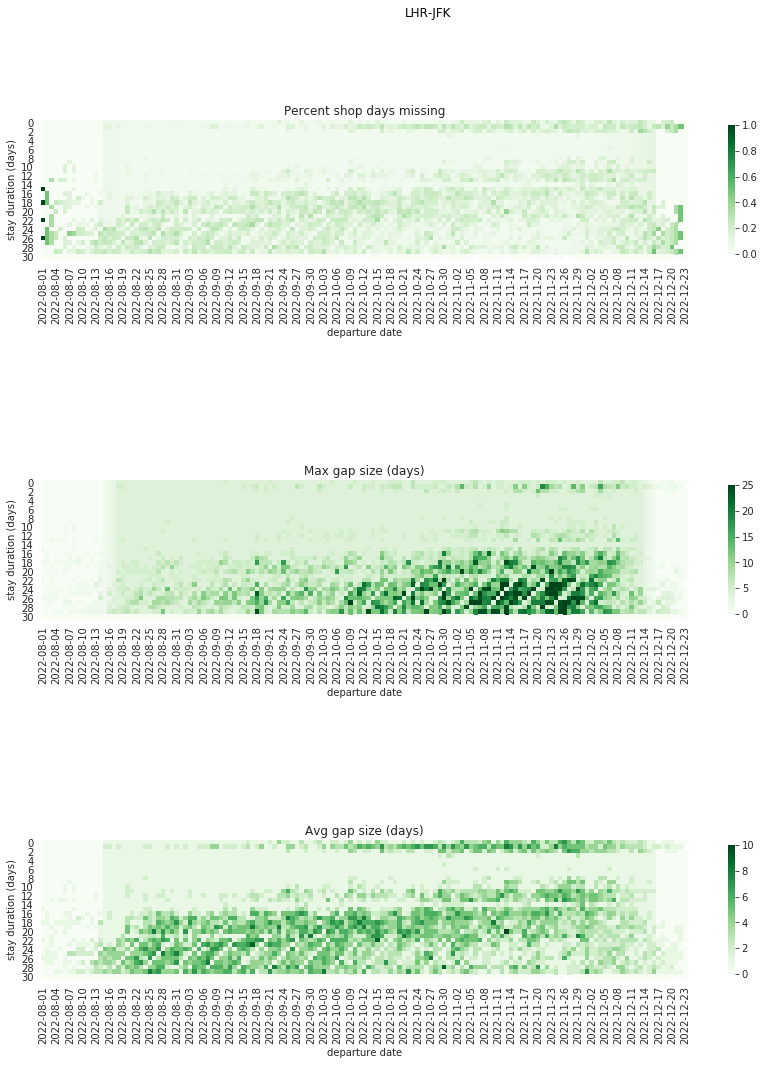

In [33]:
fig1, _ = plt.subplots(3,1, figsize=(12,15))#(max_days_til_dept//5, (max_stay_duration//6)*2))

with sns.axes_style("white"):
    plt.subplot(3,1,1)
    sns.heatmap(date_pvt1, cmap='Greens', square=True,
                vmin=0,
                cbar_kws={'shrink': 0.5
#                     'label': 'avg num gaps',
                        });
    plt.title("Percent shop days missing");
    plt.ylabel("stay duration (days)")
    plt.xlabel("departure date");
    
with sns.axes_style("white"):
    plt.subplot(3,1,2)
    sns.heatmap(date_pvt2, cmap='Greens', square=True,
                vmin=0,
                cbar_kws={'shrink': 0.5
#                     'label': 'avg num gaps',
                        });
    plt.title("Max gap size (days)");
    plt.ylabel("stay duration (days)")
    plt.xlabel("departure date");

with sns.axes_style("white"):
    plt.subplot(3,1,3)
    sns.heatmap(date_pvt3, cmap='Greens', square=True,
                vmin=0,
                cbar_kws={'shrink': 0.5
#                     'label': 'avg num gaps',
                        });
    plt.title("Avg gap size (days)");
    plt.ylabel("stay duration (days)")
    plt.xlabel("departure date");

fig1.suptitle(market)
fig1.tight_layout()
plt.subplots_adjust(top=0.93, hspace=0.4)
fig1.show()

In [34]:
date_pvt4 = mrkt_pdf.pivot(index="stay_duration", 
                    columns="outDeptDt_dt", 
                    values="num_gaps")

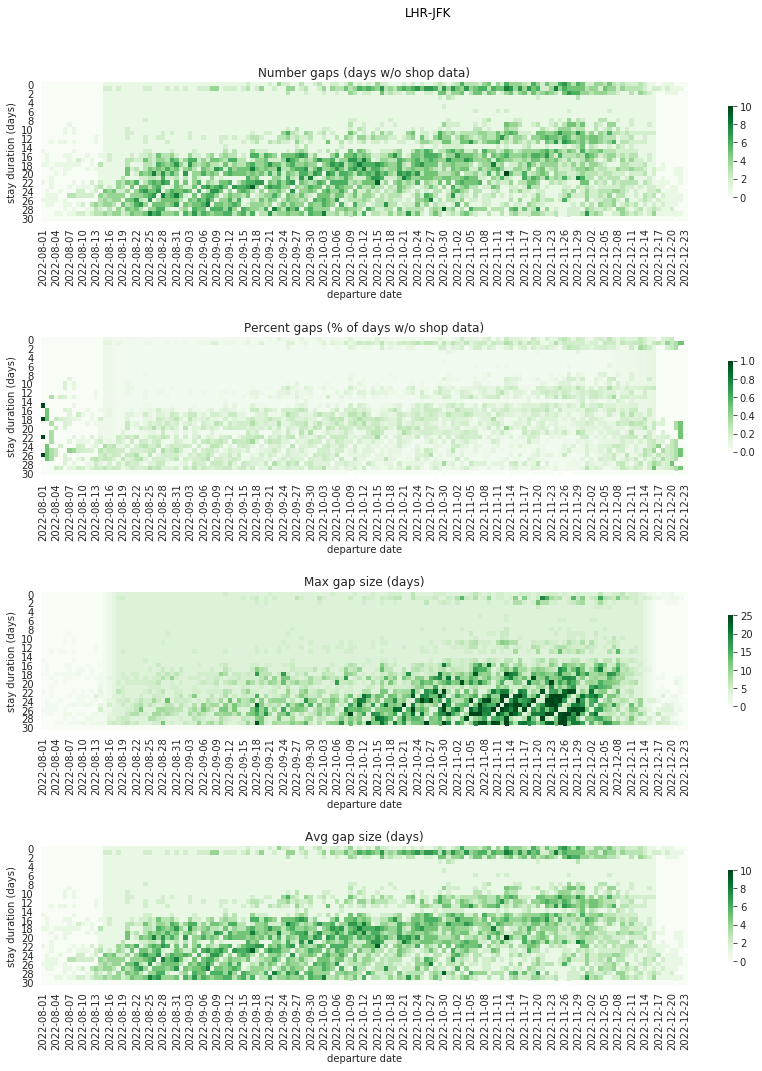

In [35]:
n = 4
i = 1
fig1, _ = plt.subplots(n,1, figsize=(12,15))#(max_days_til_dept//5, (max_stay_duration//6)*2))

with sns.axes_style("white"):
    plt.subplot(n,1,i)
    sns.heatmap(date_pvt4, cmap='Greens', square=True,
                vmin=0,
                cbar_kws={'shrink': 0.5
                    'label': 'days',
                        });
    plt.title("Number gaps (days w/o shop data)");
    plt.ylabel("stay duration (days)")
    plt.xlabel("departure date");
    
i += 1
with sns.axes_style("white"):
    plt.subplot(n,1,i)
    sns.heatmap(date_pvt1, cmap='Greens', square=True,
                vmin=0,
                cbar_kws={'shrink': 0.5
#                     'label': 'avg num gaps',
                        });
    plt.title("Percent gaps (% of days w/o shop data)");
    plt.ylabel("stay duration (days)")
    plt.xlabel("departure date");
i += 1

with sns.axes_style("white"):
    plt.subplot(n,1,i)
    sns.heatmap(date_pvt2, cmap='Greens', square=True,
                vmin=0,
                cbar_kws={'shrink': 0.5
                    'label': 'days',
                        });
    plt.title("Max gap size (days)");
    plt.ylabel("stay duration (days)")
    plt.xlabel("departure date");

i += 1
with sns.axes_style("white"):
    plt.subplot(n,1,i)
    sns.heatmap(date_pvt3, cmap='Greens', square=True,
                vmin=0,
                cbar_kws={'shrink': 0.5
                    'label': 'days',
                        });
    plt.title("Avg gap size (days)");
    plt.ylabel("stay duration (days)")
    plt.xlabel("departure date");

fig1.suptitle(market)
fig1.tight_layout()
plt.subplots_adjust(top=0.93, hspace=0.4)
fig1.show()

These we need to agg for

In [36]:

agg_dict = {"max_gap_size": "max",
            "avg_gap_size": "mean",
            "num_gaps": "mean",
#             "num_shop_days": "sum",
            "num_days_wo_shop": "sum",
            "shop_ind": ["sum", "mean"]
            }
agg_cols = ["max_gap_size", 
            "avg_gap_size",
            "avg_num_gaps",
#             "total_num_shop_days",
            "total_num_days_wo_shop",
            "total_num_days_w_shop", "pct_days_w_shop",
           ] 

agg_dtd = (mrkt_pdf
                .groupby(["days_til_dept", "stay_duration"])
                .agg(agg_dict)
            )

agg_dtd.columns = agg_cols
agg_dtd = agg_dtd.reset_index()

# agg_dept_dt = (mrkt_pdf
#                 .groupby(["outDeptDt_dt", "stay_duration"])
#                 .agg(agg_dict)
#             )
# agg_dept_dt.columns = agg_cols
# agg_dept_dt = agg_dept_dt.reset_index()

In [37]:
len(agg_dtd)

3715

In [39]:
agg_dtd.head()

,days_til_dept,stay_duration,max_gap_size,avg_gap_size,avg_num_gaps,total_num_days_wo_shop,total_num_days_w_shop,pct_days_w_shop
0,0,0,4.0,0.44,0.44,38,21,0.84
1,0,1,5.0,0.64,0.64,46,21,0.84
2,0,2,4.0,0.44,0.44,38,21,0.84
3,0,3,4.0,0.44,0.44,38,21,0.84
4,0,4,4.0,0.44,0.44,38,21,0.84


In [40]:
# dtd_pvt1 = agg_dtd.pivot(index="stay_duration", 
#                         columns="days_til_dept", 
#                         values="norm_num_gaps")

dtd_pvt2 = agg_dtd.pivot(index="stay_duration", 
                    columns="days_til_dept", 
                    values="max_gap_size")

dtd_pvt3 = agg_dtd.pivot(index="stay_duration", 
                    columns="days_til_dept", 
                    values="avg_gap_size")

dtd_pvt4 = agg_dtd.pivot(index="stay_duration", 
                    columns="days_til_dept", 
                    values="avg_num_gaps")

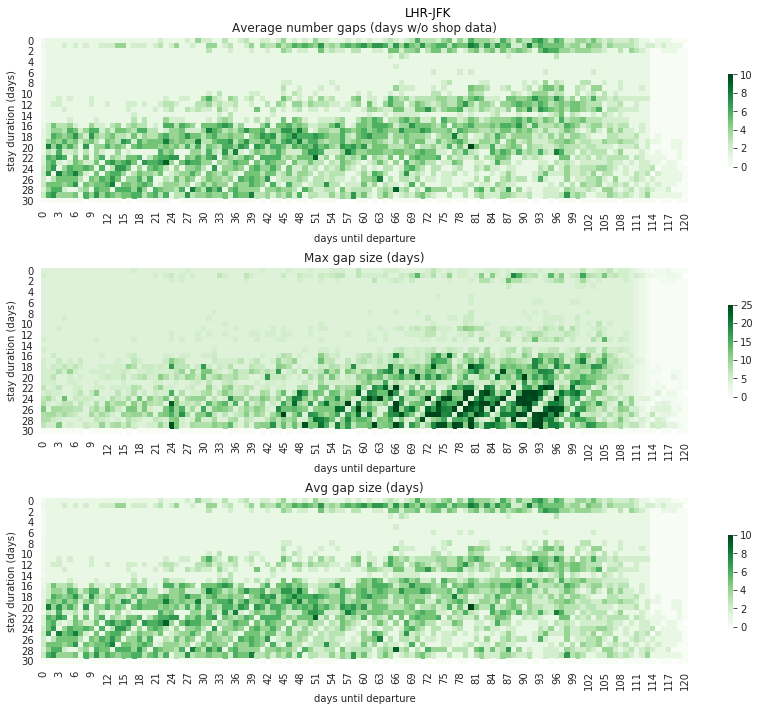

In [47]:
n = 3
i = 1
x_label = "days until departure"
fig1, _ = plt.subplots(n,1, figsize=(12, 10))#(max_days_til_dept//5, (max_stay_duration//6)*2))

with sns.axes_style("white"):
    plt.subplot(n,1,i)
    sns.heatmap(dtd_pvt4, cmap='Greens', square=True,
                vmin=0,
                cbar_kws={'shrink': 0.5
#                     'label': 'avg num gaps',
                        });
    plt.title("Average number gaps (days w/o shop data)");
    plt.ylabel("stay duration (days)")
    plt.xlabel(x_label);
i += 1

with sns.axes_style("white"):
    plt.subplot(n,1,i)
    sns.heatmap(dtd_pvt2, cmap='Greens', square=True,
                vmin=0,
                cbar_kws={'shrink': 0.5
#                     'label': 'avg num gaps',
                        });
    plt.title("Max gap size (days)");
    plt.ylabel("stay duration (days)")
    plt.xlabel(x_label);

i += 1
with sns.axes_style("white"):
    plt.subplot(n,1,i)
    sns.heatmap(dtd_pvt3, cmap='Greens', square=True,
                vmin=0,
                cbar_kws={'shrink': 0.5
#                     'label': 'avg num gaps',
                        });
    plt.title("Avg gap size (days)");
    plt.ylabel("stay duration (days)")
    plt.xlabel(x_label);

fig1.suptitle(market)
fig1.tight_layout()
plt.subplots_adjust(top=0.94, hspace=0.25)
fig1.show()

PLOT ALL THE THINGS SIDE BY SIDE??

# define funcs

In [51]:
def process_base(market, input_df):
    mrkt_df = input_df.filter(F.col("market") == market)

    join_cols = ['outDeptDt_dt', 'stay_duration', 'searchDt_dt']

    # join with enum date df
    mrkt_join_df = (mrkt_df.join(date_cross_df, 
                                on=join_cols, 
                                how='outer')
                        .fillna(0, subset=['sum_solution_counts', 'sum_shop_counts', 'shop_ind'])
                )

    # calculate `days_til_dept`
    mrkt_join_df = mrkt_join_df.withColumn('days_til_dept',
                    F.datediff(
                        F.col('outDeptDt_dt'), F.col('searchDt_dt'))
                    )

    # And then filter on it
    mrkt_join_df = mrkt_join_df.filter(F.col('days_til_dept').between(0, max_days_til_dept))

    return mrkt_join_df


def window_calcs_shops(market, mrkt_join_df, window_size=3):

    # WINDOW CALCS
    # - must do window calc's after cross-join with enum date df
    #   so the 0's are included in window calcs
    # - want to use rows rather than range here, since we are excluding missing search days
    #   (otherwise, rows vs. range approach *should* be equivalent)
    
    # Note: if using rangeBetween, must convert date to long (via ts) 
    # mrkt_join_df.createOrReplaceTempView("mdf")
    # mrkt_join_df = spark.sql("""
    #     SELECT *,
    #         CAST(searchDt_dt as TIMESTAMP) AS searchDt_ts
    #     FROM mdf
    # """)
    # mrkt_join_df = mrkt_join_df.withColumn("searchDt_long", F.col("searchDt_ts").cast('long'))


    window = (Window.partitionBy('outDeptDt_dt', 'stay_duration')
    #                 .orderBy('searchDt_long')
    #                 .rangeBetween(-sec_in_day(window_size-1), 0)
                    .orderBy('searchDt_dt')
                    .rowsBetween(-(window_size-1), Window.currentRow)
            )

    market_window_df = (mrkt_join_df
            .withColumn("sum_solutions_window", F.sum("sum_solution_counts").over(window))
            .withColumn("num_shop_days_window", F.sum("shop_ind").over(window))
            .withColumn("avg_solutions_window", F.mean("sum_solution_counts").over(window))
            .withColumn("avg_shop_days", F.mean("shop_ind").over(window))
            )

    # add this for filtering out the first rows in a window, which don't have complete aggregates
    # Note: can't have restriction on rowsBetween for row_number calc
    # so must do as a separate window calc
    window2 = (Window.partitionBy('outDeptDt_dt', 'stay_duration')
                    .orderBy('searchDt_dt')
            )

    market_window_df2 = (market_window_df
                .withColumn("grp_num", F.row_number().over(window2))         
            )

    market_window_df2 = market_window_df2.filter(F.col("grp_num") >= window_size)

    # send to Pandas for plotting
    mrkt_pdf = market_window_df2.toPandas()

    return market_pdf


from itertools import groupby

def _inspect_gaps(arr, gap_val=0):
    grp_arr = [(k, sum(1 for _ in num)) for k, num in groupby(arr)]
    gap_tuples = [v for k,v in grp_arr if k == gap_val]
    if len(gap_tuples) == 0:
        return 0.0, 0.0, 0.0
    else:
        return float(max(gap_tuples)), float(len(gap_tuples)), float(np.mean(gap_tuples))

# inspect_gaps = F.udf(_inspect_gaps, T.ArrayType(T.IntegerType()))
inspect_gaps = F.udf(_inspect_gaps, T.ArrayType(T.FloatType()))



def window_calcs_gaps(market, mrkt_join_df):

        w = (Window.partitionBy('outDeptDt_dt', 'stay_duration')
                        .orderBy('searchDt_dt')
                        .rowsBetween(Window.unboundedPreceding, Window.currentRow)
                )

        win_df = (mrkt_join_df
                .withColumn("values", F.collect_list("shop_ind").over(w))
                .withColumn("num_days_w_shop", F.sum("shop_ind").over(w))
                )

        win_df = (win_df
                .withColumn("num_shop_days", F.size(F.col("values")))
                .withColumn("num_days_wo_shop", F.col("num_shop_days") - F.col("num_days_w_shop"))
                .withColumn("gap_analysis", inspect_gaps(F.col("values")))
                .withColumn("num_gaps", F.col("gap_analysis").getItem(1))
                .withColumn("max_gap_size", F.col("gap_analysis").getItem(0))
                .withColumn("avg_gap_size", F.col("gap_analysis").getItem(1))
                .withColumn("norm_max_gap_size", F.col("max_gap_size")/F.col("num_shop_days"))
                .withColumn("norm_num_gaps", F.col("num_gaps")/F.col("num_shop_days"))
                )

        # add group number, for filtering
        w2 = (Window
        .partitionBy("outDeptDt_dt", "stay_duration")
        .orderBy(F.desc("searchDt_dt"))
        )
        win_df_filt = (win_df
                .withColumn("grp_num", F.row_number().over(w2))
                .filter(F.col("grp_num") == 1)
                )
        mrkt_pdf = win_df_filt.toPandas()
        return mrkt_pdf


In [50]:


# from 04c notebook
from imghdr import what

"""
See `preprocess-to-plot.py` for preprocessing that generates `market_pdf`, 
the inputs for our plotting function.
"""


def pivot_plot_shops(market, market_pdf, what_to_plot="shops", save_fig=False):
    """
    params:
    --------
    what_to_plot (str): ["shops", "vol", "both"]
    """
    # AGGREGATE DATA
    agg_cols = ["num_shop_days", "avg_pct_coverage_shop", 
                "total_num_solutions", "avg_num_solutions"] 
    agg_dict = {"shop_ind": "sum", 
                            "avg_shop_days": "mean",
                            "sum_solution_counts": ["sum", "mean"]
                        }

    agg_dtd = (market_pdf
                    .groupby(["days_til_dept", "stay_duration"])
                    .agg(agg_dict)
                )
    agg_dtd.columns = agg_cols
    agg_dtd = agg_dtd.reset_index()

    agg_dept_dt = (market_pdf
                    .groupby(["outDeptDt_dt", "stay_duration"])
                    .agg(agg_dict)
                )
    agg_dept_dt.columns = agg_cols
    agg_dept_dt = agg_dept_dt.reset_index()


    # PIVOT & PLOT
    file_name = (market + "_shop-dts_" + shop_start_str + "_" + shop_end_str 
                + "_travel-dtd_" + str(max_days_til_dept) + "-days")

    # number of shop days -- a boolean
    if what_to_plot in ["shops", "both"]:
        file_name += "_shop-bool"

        pvt1 = agg_dept_dt.pivot(index="stay_duration", 
                                columns="outDeptDt_dt", 
                                values="num_shop_days")

        pvt2 = agg_dept_dt.pivot(index="stay_duration", 
                            columns="outDeptDt_dt", 
                            values="avg_pct_coverage_shop")

        pvt3 = agg_dtd.pivot(index="stay_duration", 
                            columns="days_til_dept", 
                            values="num_shop_days")

        pvt4 = agg_dtd.pivot(index="stay_duration", 
                            columns="days_til_dept", 
                            values="avg_pct_coverage_shop")

        # vs departure date
        fig1, _ = plt.subplots(2,1, figsize=(max_days_til_dept//5, (max_stay_duration//6)*2))
        with sns.axes_style("white"):
            plt.subplot(2,1,1)
            sns.heatmap(pvt1, cmap='Greens', square=True,
                        vmin=0,
                        cbar_kws={'label': 'number days w/ a shop',
                                'shrink': 0.5});
            plt.title("Total num shop days");
            plt.ylabel("stay duration (days)")
            plt.xlabel("departure date");

        with sns.axes_style("white"):
            plt.subplot(2,1,2)
            sns.heatmap(pvt2, cmap='Greens', square=True,
                        vmin=0, vmax=1.0,
                        cbar_kws={'label': 'avg % coverage',
                                'shrink': 0.5});
            plt.title("Average % Coverage - rolling 3-day window of shopping");
            plt.ylabel("stay duration (days)")
            plt.xlabel("departure date");
            
        fig1.suptitle(market)
        fig1.tight_layout()
        plt.subplots_adjust(top=0.93, hspace=0.4)
        fig1.show()

        if save_fig:
            plt.savefig(out_dir + file_name + "_by-dept-date.png", format="png")


        # vs days til dept
        fig2, _ = plt.subplots(2,1, figsize=(max_days_til_dept//5, (max_stay_duration//6)*2))
        with sns.axes_style("white"):
            plt.subplot(2,1,1)
            sns.heatmap(pvt3, cmap='Greens', square=True,
                        vmin=0,
                        cbar_kws={'label': 'num shop days',
                                'shrink': 0.5});
            plt.title("Num shop days");
            plt.ylabel("stay duration (days)")
            plt.xlabel("days until departure");

        with sns.axes_style("white"):
            plt.subplot(2,1,2)
            sns.heatmap(pvt4, cmap='Greens', square=True,
                        vmin=0, vmax=1.0,
                        cbar_kws={'label': 'avg % coverage (shop days)',
                                'shrink': 0.5});
            plt.title("Average % Coverage - rolling 3-day window");
            plt.ylabel("stay duration (days)")
            plt.xlabel("days until departure");

        fig2.suptitle(market)
        fig2.tight_layout()
        plt.subplots_adjust(top=0.93, hspace=0.3)
        fig2.show()

        if save_fig:
            plt.savefig(out_dir + file_name + "_by-days-til-dept.png", format="png")
        

    # number of solutions
    if what_to_plot in ["vol", "both"]:
        file_name += "_num-sol"

        pvt1 = agg_dept_dt.pivot(index="stay_duration", 
                                columns="outDeptDt_dt", 
                                values="total_num_solutions")

        pvt2 = agg_dept_dt.pivot(index="stay_duration", 
                            columns="outDeptDt_dt", 
                            values="avg_num_solutions")

        pvt3 = agg_dtd.pivot(index="stay_duration", 
                            columns="days_til_dept", 
                            values="total_num_solutions")

        pvt4 = agg_dtd.pivot(index="stay_duration", 
                            columns="days_til_dept", 
                            values="avg_num_solutions")


        # vs dept date
        fig1, _ = plt.subplots(2,1, figsize=(max_days_til_dept//5, (max_stay_duration//6)*2))
        with sns.axes_style("white"):
            plt.subplot(2,1,1)
            sns.heatmap(pvt1, cmap='Greens', square=True,
                        vmin=0, robust=True,
                        cbar_kws={'label': 'num solutions',
                                'shrink': 0.5});
            plt.title("Total number of solutions");
            plt.ylabel("stay duration (days)")
            plt.xlabel("departure date");

        with sns.axes_style("white"):
            plt.subplot(2,1,2)
            sns.heatmap(pvt2, cmap='Greens', square=True,
                        vmin=0, robust=True,
                        cbar_kws={'label': 'avg num solutions',
                                'shrink': 0.5});
            plt.title("Average number solutions - rolling 3-day window");
            plt.ylabel("stay duration (days)")
            plt.xlabel("departure date");

        fig1.suptitle(market)
        fig1.tight_layout()
        plt.subplots_adjust(top=0.93, hspace=0.4)
        fig1.show()

        if save_fig:
            plt.savefig(out_dir + file_name + "_by-dept-date.png", format="png")

        # vs days til dept
        fig2, _ = plt.subplots(2,1, figsize=(max_days_til_dept//5, (max_stay_duration//6)*2))
        with sns.axes_style("white"):
            plt.subplot(2,1,1)
            sns.heatmap(pvt3, cmap='Greens', square=True,
                        vmin=0, robust=True,
                        cbar_kws={'label': 'num solutions',
                                'shrink': 0.5});
            plt.title("Total number of solutions");
            plt.ylabel("stay duration (days)")
            plt.xlabel("days until departure");

        with sns.axes_style("white"):
            plt.subplot(2,1,2)
            sns.heatmap(pvt4, cmap='Greens', square=True,
                        vmin=0, robust=True,
                        cbar_kws={'label': 'avg num solutions',
                                'shrink': 0.5});
            plt.title("Average number solutions - rolling 3-day window");
            plt.ylabel("stay duration (days)")
            plt.xlabel("days until departure");
            

        fig2.suptitle(market)
        fig2.tight_layout()
        plt.subplots_adjust(top=0.93, hspace=0.3)
        fig2.show()

        if save_fig:
            plt.savefig(out_dir + file_name + "_by-days-til-dept.png", format="png")



def plot_gaps_by_dept_dt(market, mrkt_pdf, save_fig=False):
    date_pvt1 = mrkt_pdf.pivot(index="stay_duration", 
                        columns="outDeptDt_dt", 
                        values="norm_num_gaps")

    date_pvt2 = mrkt_pdf.pivot(index="stay_duration", 
                        columns="outDeptDt_dt", 
                        values="max_gap_size")

    date_pvt3 = mrkt_pdf.pivot(index="stay_duration", 
                        columns="outDeptDt_dt", 
                        values="avg_gap_size")

    date_pvt4 = mrkt_pdf.pivot(index="stay_duration", 
                    columns="outDeptDt_dt", 
                    values="num_gaps")
    
    n = 3
    i = 1
    fig1, _ = plt.subplots(n,1, figsize=(12,15))#(max_days_til_dept//5, (max_stay_duration//6)*2))

    with sns.axes_style("white"):
        plt.subplot(n,1,i)
        sns.heatmap(date_pvt4, cmap='Greens', square=True,
                    vmin=0,
                    cbar_kws={'shrink': 0.5,
                        'label': 'days',
                    });
        plt.title("Number gaps (days w/o shop data)");
        plt.ylabel("stay duration (days)")
        plt.xlabel("departure date");
        
    i += 1
    with sns.axes_style("white"):
        plt.subplot(n,1,i)
        sns.heatmap(date_pvt2, cmap='Greens', square=True,
                    vmin=0,
                    cbar_kws={'shrink': 0.5,
                        'label': 'days',
                    });
        plt.title("Max gap size (days)");
        plt.ylabel("stay duration (days)")
        plt.xlabel("departure date");
    
    i += 1
    with sns.axes_style("white"):
        plt.subplot(n,1,i)
        sns.heatmap(date_pvt3, cmap='Greens', square=True,
                    vmin=0,
                    cbar_kws={'shrink': 0.5,
                        'label': 'days',
                        });
        plt.title("Avg gap size (days)");
        plt.ylabel("stay duration (days)")
        plt.xlabel("departure date");

    fig1.suptitle(market)
    fig1.tight_layout()
    plt.subplots_adjust(top=0.93, hspace=0.4)
    fig1.show()

def plot_gaps_by_days_til_dept(market, mrkt_pdf, save_fig=True):

    agg_dict = {"max_gap_size": "max",
                "avg_gap_size": "mean",
                "num_gaps": "mean",
                "num_days_wo_shop": "sum",
                "shop_ind": ["sum", "mean"]
                }
    agg_cols = ["max_gap_size", 
                "avg_gap_size",
                "avg_num_gaps",
                "total_num_days_wo_shop",
                "total_num_days_w_shop", "pct_days_w_shop",
            ] 

    agg_dtd = (mrkt_pdf
                    .groupby(["days_til_dept", "stay_duration"])
                    .agg(agg_dict)
                )

    agg_dtd.columns = agg_cols
    agg_dtd = agg_dtd.reset_index()

    dtd_pvt2 = agg_dtd.pivot(index="stay_duration", 
                    columns="days_til_dept", 
                    values="max_gap_size")

    dtd_pvt3 = agg_dtd.pivot(index="stay_duration", 
                        columns="days_til_dept", 
                        values="avg_gap_size")

    dtd_pvt4 = agg_dtd.pivot(index="stay_duration", 
                        columns="days_til_dept", 
                        values="avg_num_gaps")

    n = 3
    i = 1
    x_label = "days until departure"
    fig1, _ = plt.subplots(n,1, figsize=(12, 10))#(max_days_til_dept//5, (max_stay_duration//6)*2))

    with sns.axes_style("white"):
        plt.subplot(n,1,i)
        sns.heatmap(dtd_pvt4, cmap='Greens', square=True,
                    vmin=0,
                    cbar_kws={'shrink': 0.5,
                        'label': 'days',
                            });
        plt.title("Average number gaps (days w/o shop data)");
        plt.ylabel("stay duration (days)")
        plt.xlabel(x_label);
    i += 1

    with sns.axes_style("white"):
        plt.subplot(n,1,i)
        sns.heatmap(dtd_pvt2, cmap='Greens', square=True,
                    vmin=0,
                    cbar_kws={'shrink': 0.5,
                        'label': 'days',
                            });
        plt.title("Max gap size (days)");
        plt.ylabel("stay duration (days)")
        plt.xlabel(x_label);

    i += 1
    with sns.axes_style("white"):
        plt.subplot(n,1,i)
        sns.heatmap(dtd_pvt3, cmap='Greens', square=True,
                    vmin=0,
                    cbar_kws={'shrink': 0.5,
                        'label': 'days',
                            });
        plt.title("Avg gap size (days)");
        plt.ylabel("stay duration (days)")
        plt.xlabel(x_label);

    fig1.suptitle(market)
    fig1.tight_layout()
    plt.subplots_adjust(top=0.94, hspace=0.25)
    fig1.show()

In [52]:
market = 'JFK-LHR'
market_df = process_base(market, cnt_df)
market_pdf = window_calcs_gaps(market, market_df)
plot_gaps_by_days_til_dept(market, market_pdf, False)

Py4JJavaError: An error occurred while calling o353.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 4 in stage 57.0 failed 1 times, most recent failure: Lost task 4.0 in stage 57.0 (TID 177, localhost, executor driver): java.io.FileNotFoundException: File does not exist: hdfs://ngsearchdev/user/kendra.frederick/shop_vol/encoded/markets/v2/part-00000-6590a276-029a-4b6a-acd2-39e0e935553c.snappy.parquet
It is possible the underlying files have been updated. You can explicitly invalidate the cache in Spark by running 'REFRESH TABLE tableName' command in SQL or by recreating the Dataset/DataFrame involved.
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:175)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:109)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIterator.scan_nextBatch$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIterator.agg_doAggregateWithKeys$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIterator.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$8$$anon$1.hasNext(WholeStageCodegenExec.scala:377)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:126)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:322)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1435)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1423)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1422)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1422)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1650)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1605)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1594)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:628)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1925)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1938)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1951)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1965)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:936)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:362)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:935)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:275)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply$mcI$sp(Dataset.scala:2760)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:2757)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:2757)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:57)
	at org.apache.spark.sql.Dataset.withNewExecutionId(Dataset.scala:2780)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:2757)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)
Caused by: java.io.FileNotFoundException: File does not exist: hdfs://ngsearchdev/user/kendra.frederick/shop_vol/encoded/markets/v2/part-00000-6590a276-029a-4b6a-acd2-39e0e935553c.snappy.parquet
It is possible the underlying files have been updated. You can explicitly invalidate the cache in Spark by running 'REFRESH TABLE tableName' command in SQL or by recreating the Dataset/DataFrame involved.
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:175)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:109)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIterator.scan_nextBatch$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIterator.agg_doAggregateWithKeys$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIterator.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$8$$anon$1.hasNext(WholeStageCodegenExec.scala:377)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:126)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:322)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


# iter over markets

In [12]:
# where to save figures
out_dir = "./output/04/120-days/"

In [18]:
markets_to_plot = [
    'LHR-JFK',
    'DFW-ORD',
    'JFK-LAX',
    'BKK-SIN',
    'DEL-BOM',
    'SYD-MEL',
    'LHR-BKK',
    'LHR-DOH',
]

In [ ]:
for market in markets_to_plot:
    mpdf = process(market, cnt_df)
    agg_and_plot(market, mpdf, True)